In [232]:
# Uncomment the line below to install Aer package for custom depolarizing error
# !pip install qiskit-aer

In [233]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
import numpy as np
from qiskit.circuit.library import CZGate, RXGate, RYGate, UnitaryGate, TGate, XGate, YGate, CPhaseGate, HGate
from qiskit.quantum_info import Statevector, Operator, average_gate_fidelity, random_clifford, Clifford
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit_aer.noise import depolarizing_error, NoiseModel, thermal_relaxation_error, coherent_unitary_error, kraus_error
from scipy.linalg import sqrtm

# Gate definition

In [234]:
# Define the gates
X90, Y90 = RXGate(np.pi / 2), RYGate(np.pi / 2)
T, X, Y, H = TGate(), XGate(), YGate(), HGate()
W = UnitaryGate((X.to_matrix()+Y.to_matrix())/np.sqrt(2), label='w')
SW = UnitaryGate(sqrtm(W.to_matrix()), label='sw')
XY90 = UnitaryGate((X90.to_matrix() + Y90.to_matrix()) / np.sqrt(3), label="XY90")
XY90mm = UnitaryGate((-X90.to_matrix() - Y90.to_matrix()) / np.sqrt(3), label="XY90mm")
XY90pm = UnitaryGate((X90.to_matrix() - Y90.to_matrix()), label="XY90pm")
XY90mp = UnitaryGate((-X90.to_matrix() + Y90.to_matrix()), label="XY90mp")
# CZ, CP = CZGate(), CPhaseGate(np.pi/2)
CZ = CPhaseGate(np.pi*1)

# Possible gate sets
gate_dict1 = {0: X90, 1: Y90, 2: T}  # https://arxiv.org/abs/1608.00263
gate_dict2 = {0: X90, 1: Y90, 2: SW}  # https://www.nature.com/articles/s41586-019-1666-5
gate_dict3 = {0: X90, 1: Y90, 2: XY90, 3: XY90mm, 4: XY90pm, 5: XY90mp} # https://arxiv.org/abs/2001.08343
gate_dict4 = {0: X90, 1: Y90, 2: XY90} 
gate_sets = [gate_dict1, gate_dict2, gate_dict3, gate_dict4]
# Set for storing unique Cliffords
cliffords = []

# Generate Cliffords until we have 24 unique ones
while len(cliffords) < 24:
    # Generate a random Clifford
    c = random_clifford(1)
    # Add it to the set (this automatically checks for uniqueness)
    if c not in cliffords:
        cliffords.append(c)

# Convert set to list
cliffords = {i: c for i, c in enumerate(cliffords)}
gate_sets.append(cliffords)

# Now cliffords list contains all 24 one-qubit Clifford operators


In [235]:
# Choose the gate set
gate_set_choice = 1 # 1, 2, 3 or 4
gate_dict = gate_sets[gate_set_choice - 1]
random_gates = len(gate_dict)
print(random_gates)

3


# Noise parameters

In [236]:
num_qubits = 2  # Number of qubits
apply_CZ = True  # Apply CZ gate
error1q = 0.01
error2q = 0.03
effective_error = error2q + num_qubits*error1q if num_qubits == 2 and apply_CZ else num_qubits*error1q
depol_error1q = depolarizing_error(error1q, 1)
depol_error2q = depolarizing_error(error2q, 2)
sq_gate_set = ["t", "rx", "ry", "u1", "u2", "u3"]
# noise_model = NoiseModel(basis_gates = sq_gate_set)
noise_model = NoiseModel()
if num_qubits == 2:
    noise_model.add_all_qubit_quantum_error(depol_error2q, ["cz"])
# noise_model.add_all_qubit_quantum_error(depol_error1q, sq_gate_set)
noise_model.add_all_qubit_quantum_error(depol_error1q, ['rz', 'sx', 'x'])
backend = AerSimulator(noise_model=noise_model, method="density_matrix", basis_gates=noise_model.basis_gates) 
print(noise_model.noise_qubits)
print(noise_model)

[]
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['cz', 'x', 'rz', 'sx']
  All-qubits errors: ['cz', 'rz', 'sx', 'x']


# Sequence parameters

In [237]:
# np.random.seed(335)
sequences = 81 # Number of sequences
max_depth = 280# Maximum depth
step = 40 # Step for depths to be tested
n_avgs = 1000 # Number of shots
np.random.seed(13111)
dim = 2 ** num_qubits
qubits = QuantumRegister(num_qubits, "q") # Number of qubits

depths = np.arange(1, max_depth + 1, step) # Depths to be tested
sq_gates, counts_list, states_list, circuits_list = [], [], [], []  # 2D for 2 qubits


# Generate random sequences

In [238]:

# Generate sequences
for s in range(sequences):  # For each sequence
    counts_list.append([])
    sq_gates.append([])
    circuits_list.append([])
    states_list.append([])
    for i, d in enumerate(depths):  # For each maximum depth
        sq_gates[s].append(np.zeros((2, d), dtype=int))
        for q in range(num_qubits):  # For each qubit
            # Generate random single qubit gates
            # Start the sequence with a random gate
            sq_gates[s][i][q][0] = np.random.randint(random_gates)
        for d_ in range(1, d):  # For each growing depth (all cycles until maximum depth d)
            for q in range(num_qubits):  # For each qubit
                sq_gates[s][i][q][d_] = np.random.randint(random_gates)
                # Make sure that the same gate is not applied twice in a row
                while sq_gates[s][i][q][d_] == sq_gates[s][i][q][d_ - 1]:
                    sq_gates[s][i][q][d_] = np.random.randint(random_gates)
        # Define the circuit
        qc = QuantumCircuit(qubits)
        # First cycle: apply Hadamard 
        for q in range(num_qubits):
            qc.append(H, [q])
        if num_qubits == 2 and apply_CZ:
            qc.append(CZ, qubits)
        for d_ in range(d):  # Apply layers
            for q in range(num_qubits):  # For each qubit, append single qubit gates
                qc.append(gate_dict[sq_gates[s][i][q][d_]], [qubits[q]])
            # Apply CZ gate
            if num_qubits == 2 and apply_CZ:
                qc.append(CZ, qubits)
        # Store the statevector
        states_list[s].append(Statevector(qc))
        circuits_list[s].append(qc)
        

/Users/adamachuck/anaconda3/envs/QPX/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


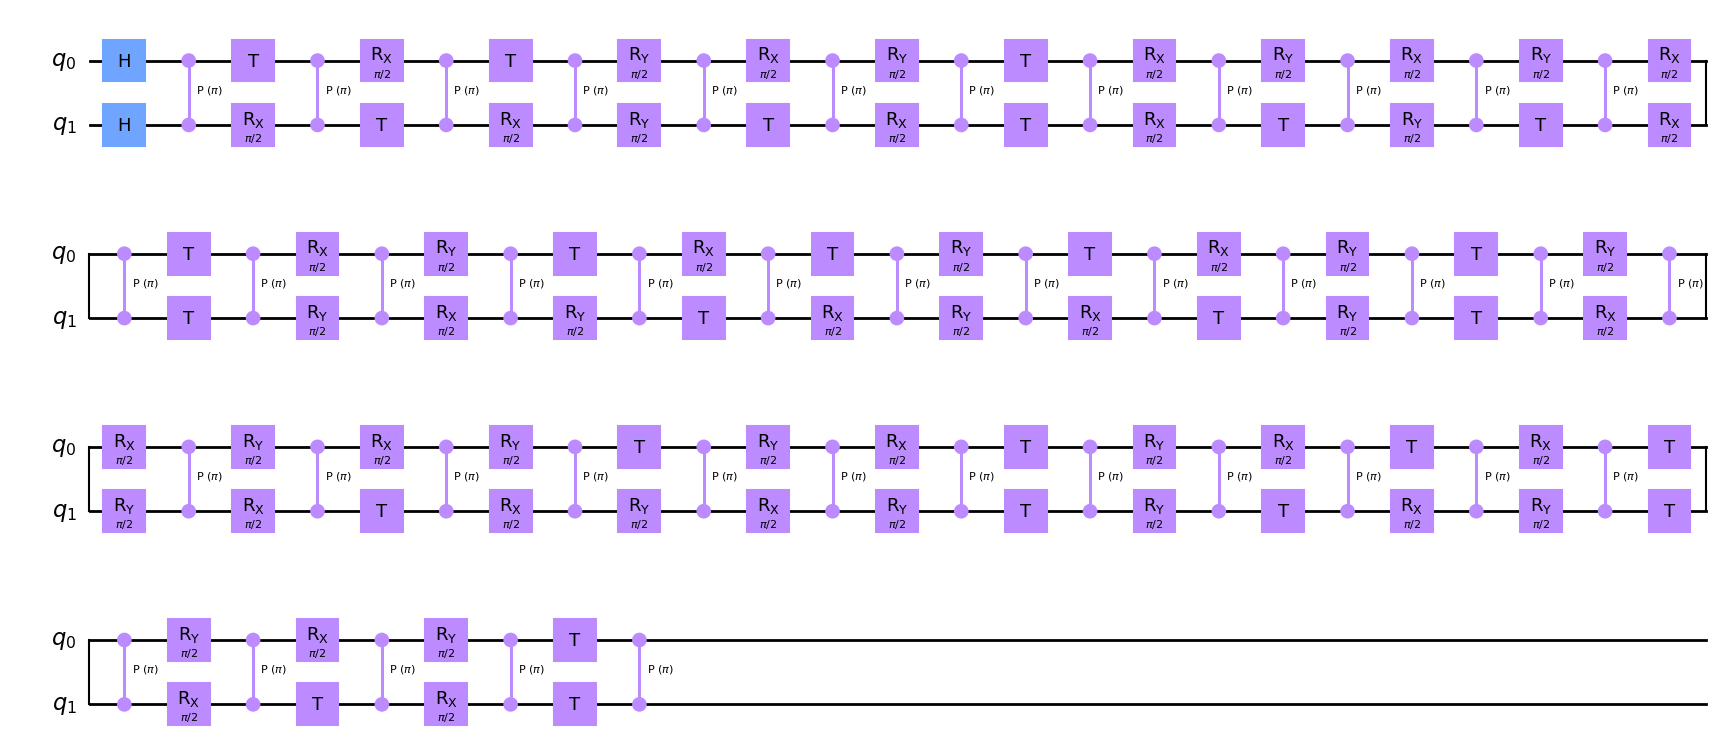

In [239]:
# Draw the circuit of your choice: first index is the sequence, second index is the depth index in depths array
circuits_list[1][1].draw(output="mpl")

In [240]:
states_list[1][0]

Statevector([-0.5+3.061617e-17j,  0.5-3.061617e-17j,  0.5-3.061617e-17j,
             -0.5+3.061617e-17j],
            dims=(2, 2))


# Execute the circuits

In [241]:
# Execute circuit (transpiled) and store counts
circ_list = [circuits_list[s][i].measure_all(inplace=False) for s in range(sequences) for i in range(len(depths))]
transpiled_circs = transpile(circ_list, backend)
job = backend.run(transpiled_circs, shots=n_avgs)
counts = job.result().get_counts()

# Add missing keys to counts (Qiskit does not add all possible outcomes by default, only the ones carrying actual counts)
for count in counts:
    for key in [bin(i)[2:].zfill(num_qubits) for i in range(dim)]:
        if key not in count.keys():
            count[key] = 0
# Add counts to list
idx = 0
for s in range(sequences):
    for i in range(len(depths)): 
        counts_list[s].append(counts[idx])
        idx += 1


# Post-processing

In [242]:
def cross_entropy(p, q, epsilon=1e-15):
    """
    Calculate cross entropy between two probability distributions.

    Parameters:
    - p: numpy array, the true probability distribution
    - q: numpy array, the predicted probability distribution
    - epsilon: small value to avoid taking the logarithm of zero

    Returns:
    - Cross entropy between p and q
    """
    q = np.maximum(q, epsilon)  # Avoid taking the logarithm of zero

    # print(f"p: {p}, \nq: {q}")

    x_entropy = -np.sum(p * np.log(q))

    return x_entropy

In [243]:
from scipy.optimize import curve_fit
# Post-processing
records = []
incoherent_dist = np.ones(dim) / dim
fidelities = np.zeros((sequences, len(depths)))
expected_probs = np.zeros((sequences, len(depths), dim))
measured_probs = np.zeros((sequences, len(depths), dim))
linear_fidelities = np.zeros((sequences, len(depths)))
noise_model_fidelities = np.zeros((sequences, len(depths)))

# Reconstruct sequence from gate indices (similar step to what is done in QUA)
for s in range(sequences):
    for j, d in enumerate(depths):
        qc = QuantumCircuit(qubits)
        for q in range(num_qubits):
            qc.append(H, [q])
        if num_qubits == 2 and apply_CZ:
            qc.append(CZ, qubits)
        for k in range(d):
            sq_gates1 = [gate_dict[sq_gates[s][j][q][k]] for q in range(num_qubits)]
            # Retrieve random single qubit gates applied on both qubits
            # Apply the gates on the state
            for q, sq_gate in enumerate(sq_gates1):
                qc.append(sq_gate, [q])
            if num_qubits == 2 and apply_CZ:
                qc.append(CZ, [0, 1])
            # print("computed state: %s" % state)
        expected_probs[s, j] = Statevector(qc).probabilities()
        measured_probs[s, j] = (
            np.array([counts_list[s][j][bin(i)[2:].zfill(num_qubits)] for i in range(dim)])
            / n_avgs
        )
        xe_incoherent = cross_entropy(incoherent_dist, expected_probs[s, j])
        xe_measured = cross_entropy(measured_probs[s, j], expected_probs[s, j])
        xe_expected = cross_entropy(expected_probs[s, j], expected_probs[s, j])
        
        f_log_xeb = (xe_incoherent - xe_measured) / (xe_incoherent - xe_expected)
        f_linear_xeb = np.sum(measured_probs[s, j] * (dim *  expected_probs[s, j] -1))
        fidelities[s, j] = f_log_xeb
        linear_fidelities[s, j] = f_linear_xeb
        noise_model_fidelities[s, j] = (1-effective_error)**d
        
        # print(f"seq {s + 1}, depth {depths[j]}: f_xeb = {f_xeb}")
        
        records += [
            {
                "sequence": s,
                "depth": depths[j],
                "pure_probs": expected_probs[s, j],
                # "pure_probs": states_list[s][j].probabilities(),
                "sampled_probs": measured_probs[s, j],
                "circuit": circuits_list[s][j],
            }
        ]

Fxeb = np.mean(fidelities, axis=0)
Flinear = np.mean(linear_fidelities, axis=0)
Fnoise = np.mean(noise_model_fidelities, axis=0)
for record in records:
    e_u = np.sum(record["pure_probs"] ** 2)
    u_u = np.sum(record["pure_probs"]) / dim
    m_u = np.sum(record["pure_probs"] * record["sampled_probs"])
    record.update(e_u=e_u, u_u=u_u, m_u=m_u)

# State Heatmap

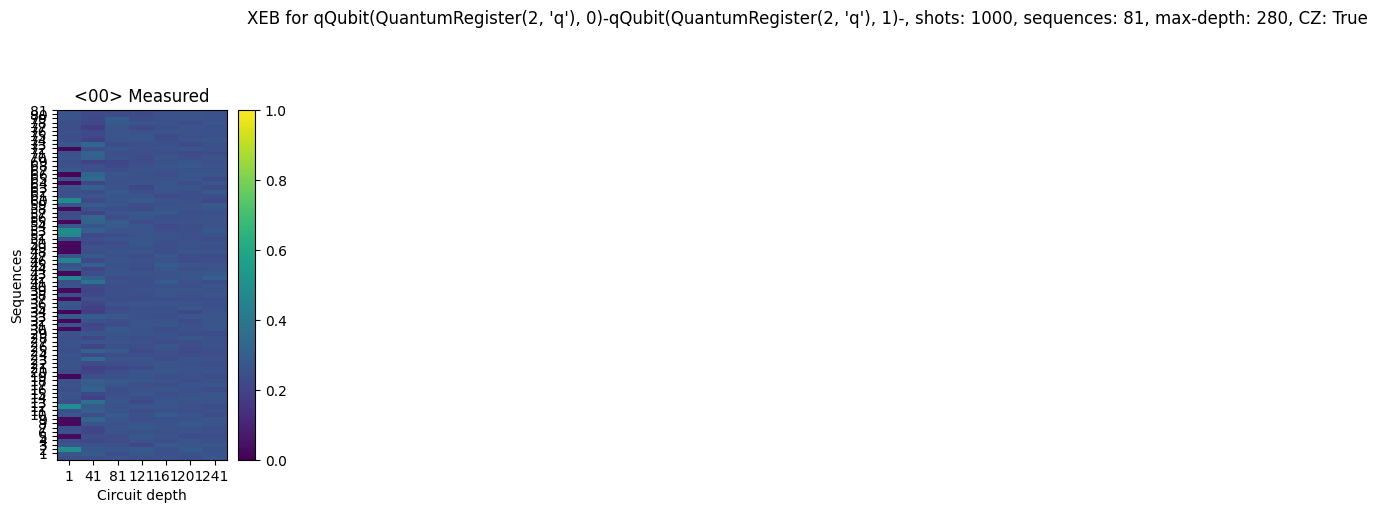

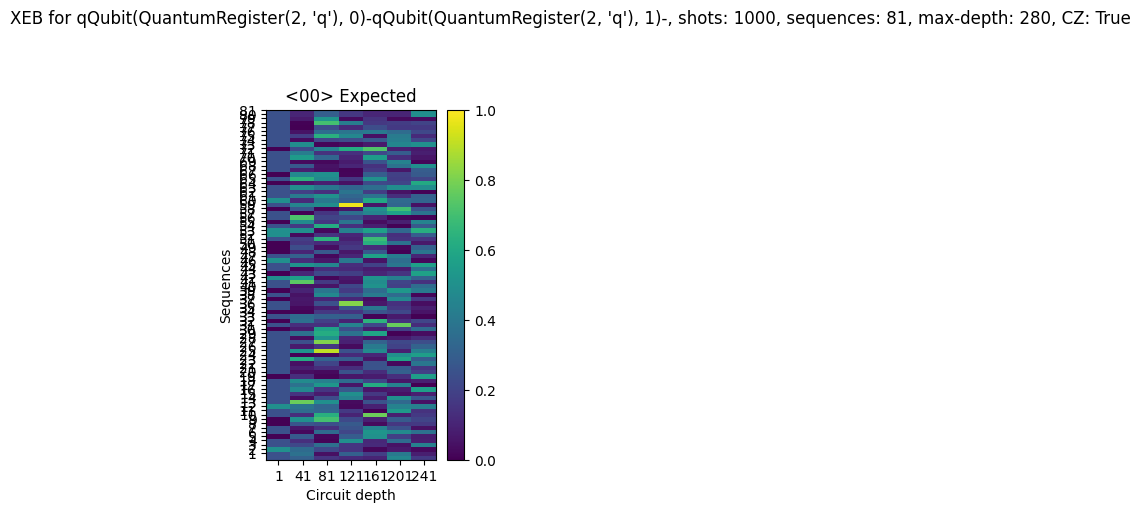

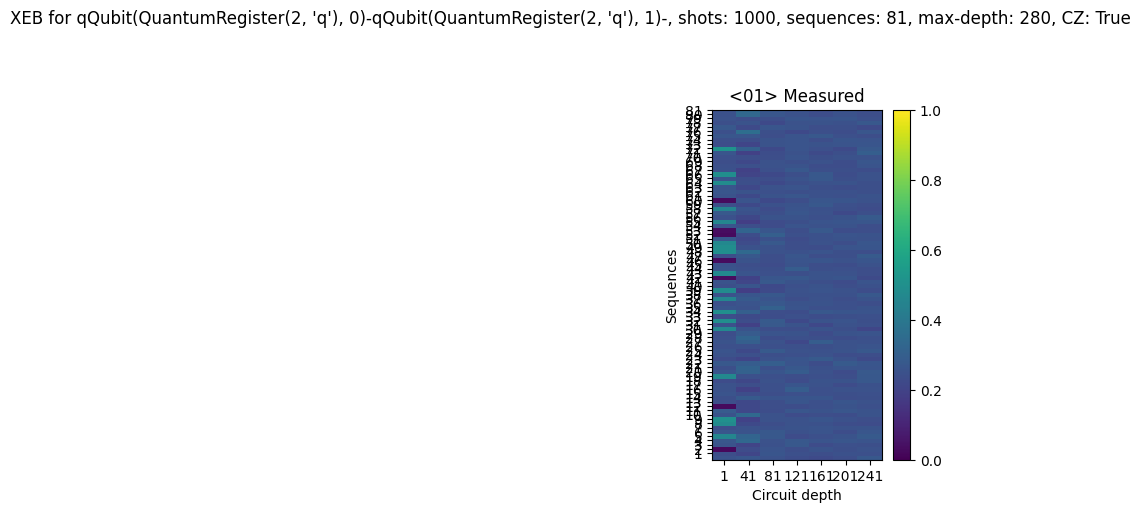

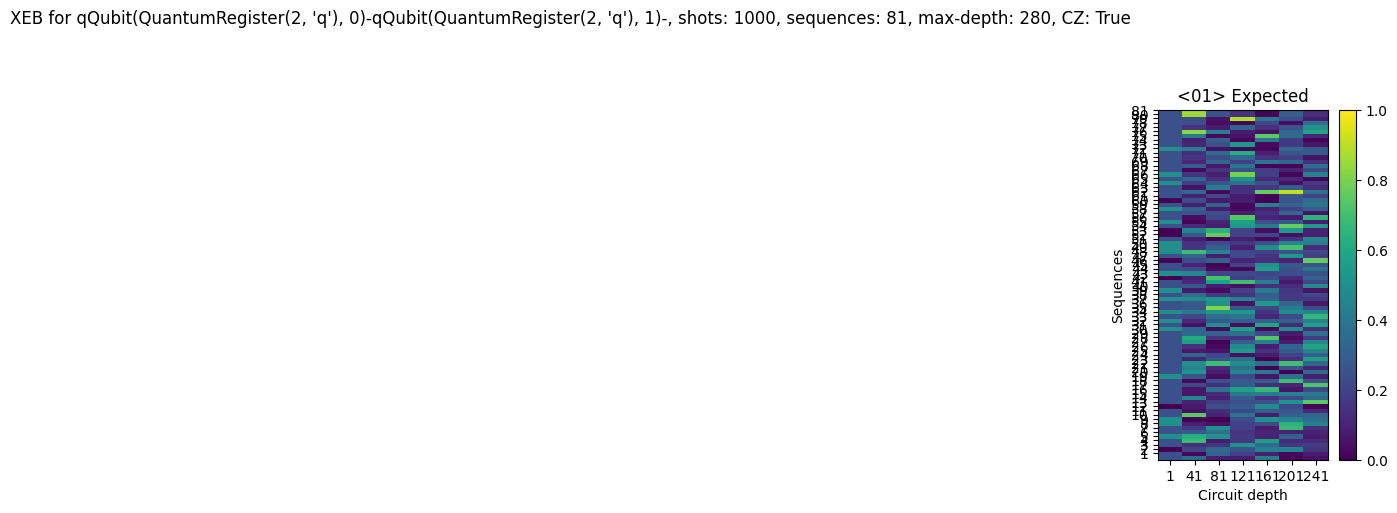

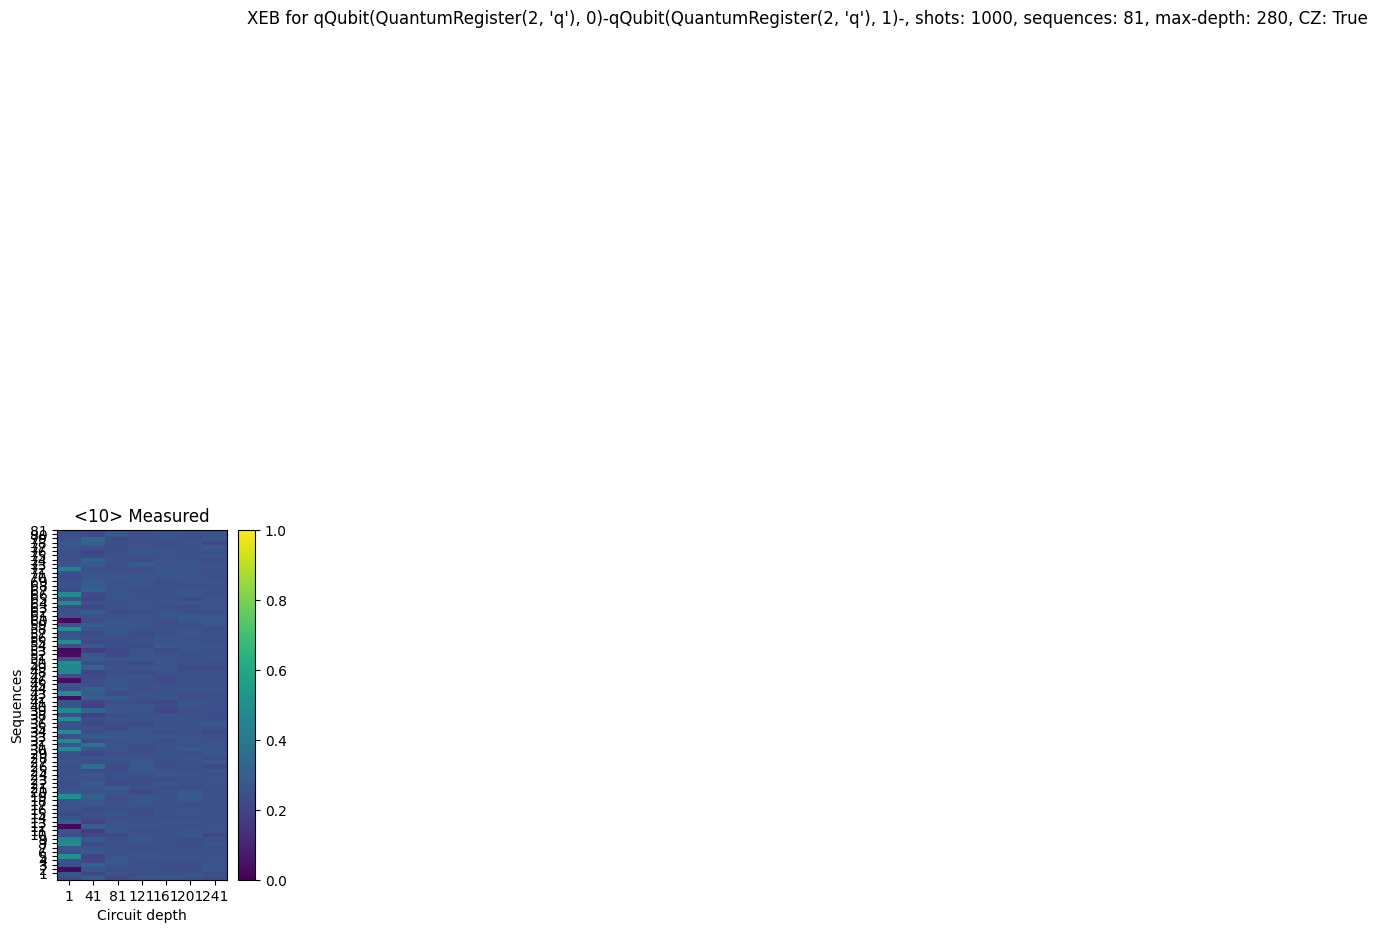

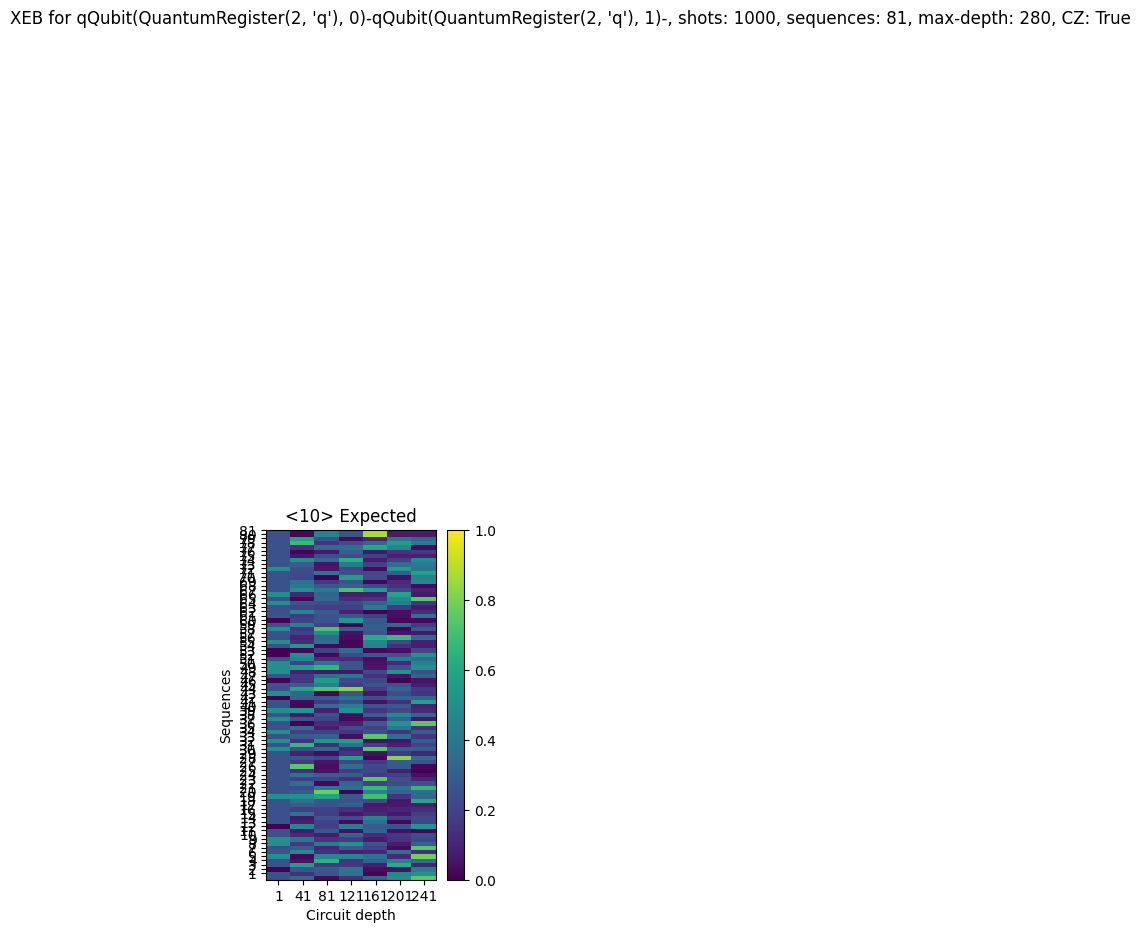

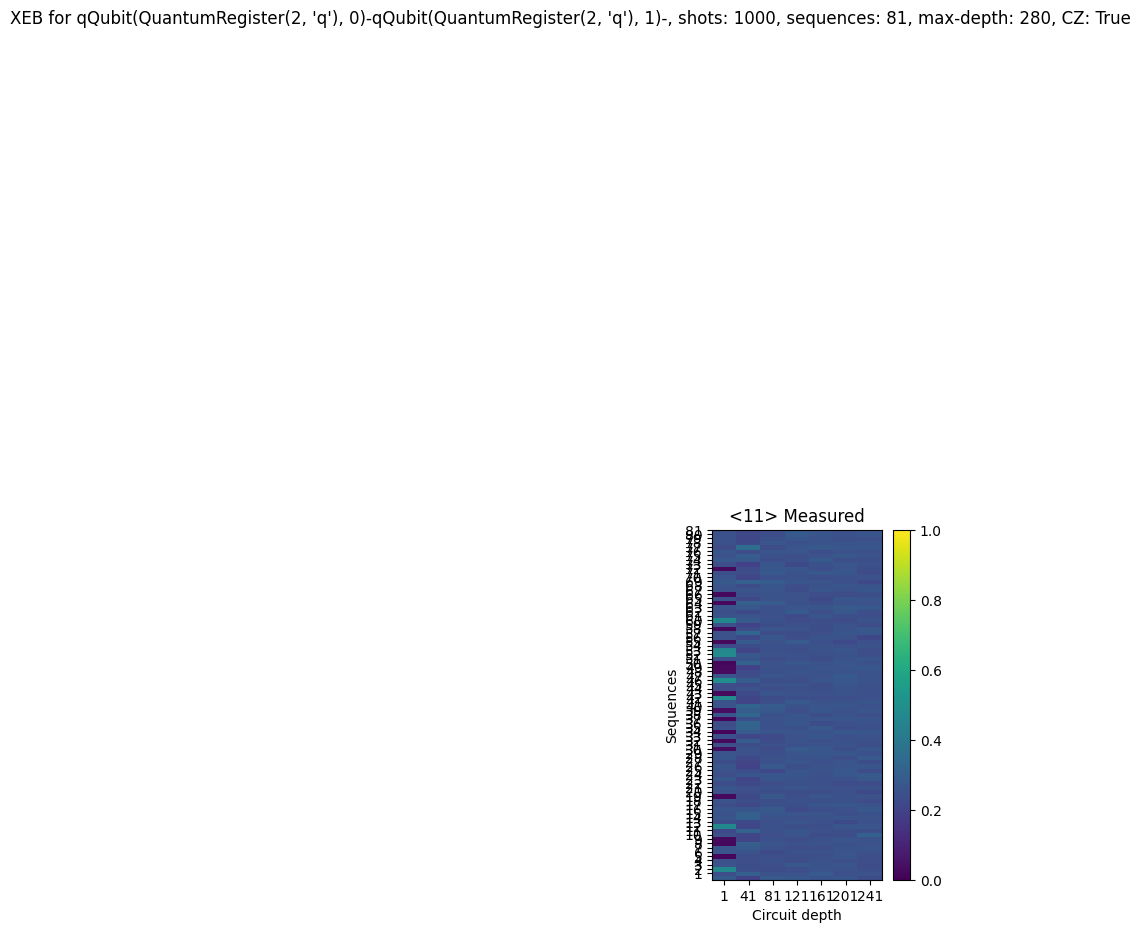

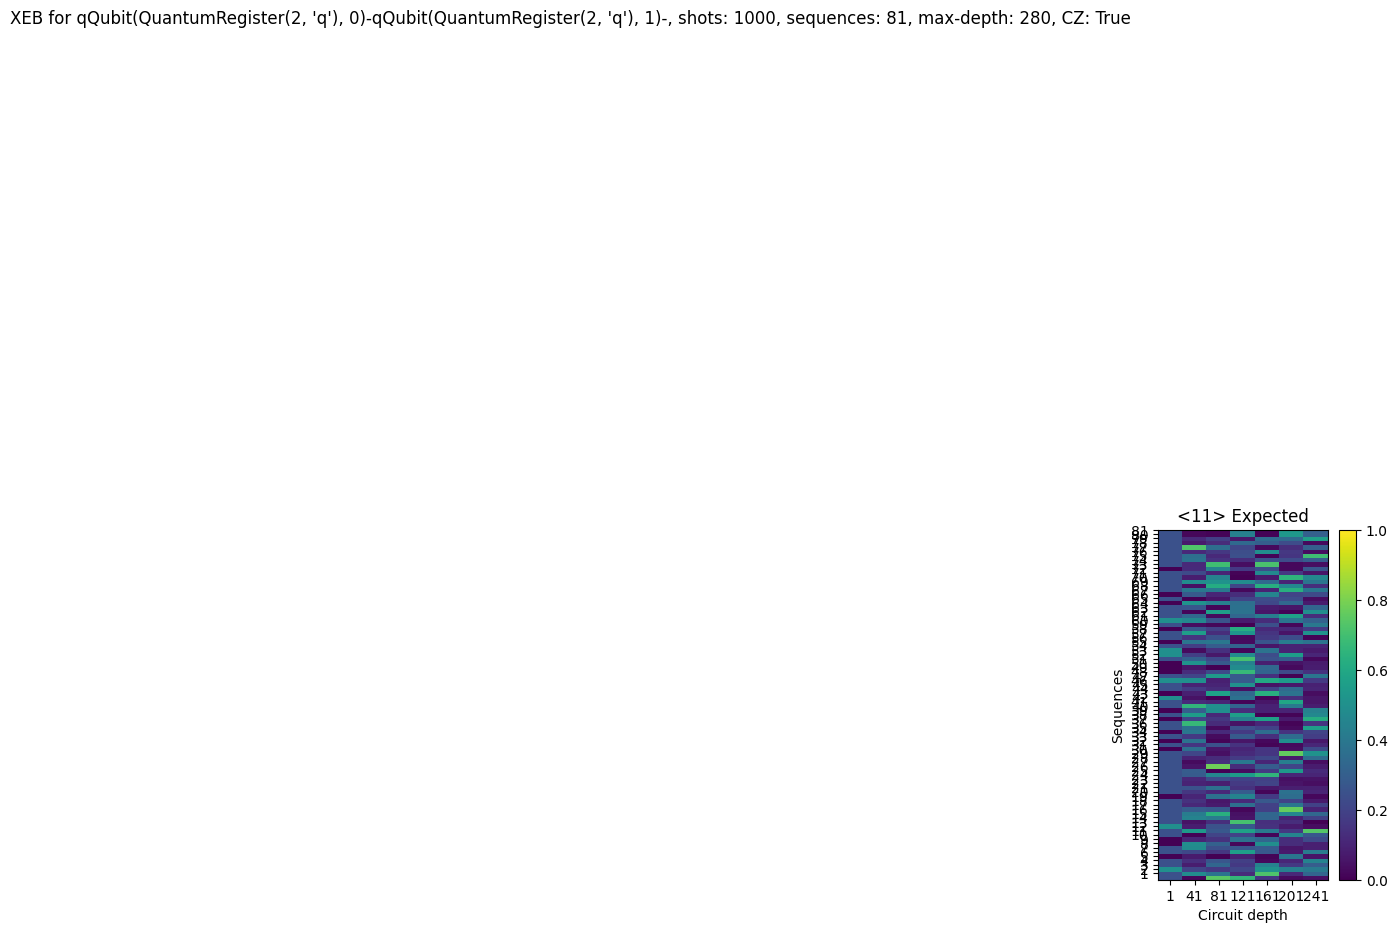

In [244]:
# Plot the results
def create_subplot(data, subplot_number, title):
    plt.subplot(subplot_number)
    plt.pcolor(depths, range(sequences), np.abs(data), vmin=0., vmax=1.0)
    ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel("Circuit depth")
    ax.set_ylabel("Sequences")
    ax.set_xticks(depths)
    ax.set_yticks(np.arange(1, sequences + 1))
    plt.colorbar()

titles, data = [], []

for i in range(dim):
    titles.append(f"<{bin(i)[2:].zfill(num_qubits)}> Measured")
    titles.append(f"<{bin(i)[2:].zfill(num_qubits)}> Expected")
    data.append(measured_probs[:, :, i])
    data.append(expected_probs[:, :, i])

plot_number = [241, 242, 243, 244, 245, 246, 247, 248]

k = 0
for title, d, n in zip(titles, data, plot_number):
    plt.figure(figsize=(20, 10))
    qubits_involved = ""
    for q in qubits:
        qubits_involved += f"q{q}-"
    plt.suptitle(f"XEB for "+ qubits_involved+f", shots: {n_avgs}, sequences: {sequences}, max-depth: {max_depth}, CZ: {True if num_qubits == 2 else False}")
    create_subplot(d, n, title)
    plt.subplots_adjust(wspace=1.1)
    k+=1


In [245]:
import pandas as pd
df = pd.DataFrame(records)
df["y"] = df["m_u"] - df["u_u"]
df["x"] = df["e_u"] - df["u_u"]

df["numerator"] = df["x"] * df["y"]
df["denominator"] = df["x"] ** 2
df

,sequence,depth,pure_probs,sampled_probs,circuit,e_u,u_u,m_u,y,x,numerator,denominator
0,0,1,"[0.2499999999999999, 0.2499999999999999, 0.249...","[0.239, 0.25, 0.232, 0.279]","((Instruction(name='h', num_qubits=1, num_clbi...",0.250000,0.25,0.250000,0.000000,-1.387779e-16,-0.000000,1.925930e-32
1,0,41,"[0.3062689710506371, 0.3440545063586685, 0.332...","[0.246, 0.267, 0.289, 0.198]","((Instruction(name='h', num_qubits=1, num_clbi...",0.323105,0.25,0.266710,0.016710,7.310541e-02,0.001222,5.344402e-03
2,0,81,"[0.15223697888986998, 0.08522268315734699, 0.0...","[0.259, 0.252, 0.213, 0.276]","((Instruction(name='h', num_qubits=1, num_clbi...",0.576241,0.25,0.269845,0.019845,3.262410e-01,0.006474,1.064332e-01
3,0,121,"[0.11862819634816991, 0.0811488739120691, 0.13...","[0.248, 0.231, 0.25, 0.271]","((Instruction(name='h', num_qubits=1, num_clbi...",0.476390,0.25,0.262090,0.012090,2.263898e-01,0.002737,5.125236e-02
4,0,161,"[0.09978682311918147, 0.4215018917159296, 0.32...","[0.252, 0.224, 0.27, 0.254]","((Instruction(name='h', num_qubits=1, num_clbi...",0.316757,0.25,0.246350,-0.003650,6.675665e-02,-0.000244,4.456450e-03
...,...,...,...,...,...,...,...,...,...,...,...,...
562,80,81,"[0.29577413944411307, 0.2575150770476552, 0.43...","[0.227, 0.267, 0.275, 0.231]","((Instruction(name='h', num_qubits=1, num_clbi...",0.345977,0.25,0.258373,0.008373,9.597728e-02,0.000804,9.211638e-03
563,80,121,"[0.16321484813387474, 0.14065819767374063, 0.2...","[0.226, 0.253, 0.24, 0.281]","((Instruction(name='h', num_qubits=1, num_clbi...",0.302799,0.25,0.257254,0.007254,5.279871e-02,0.000383,2.787704e-03
564,80,161,"[0.10650899088152442, 0.014271302937602573, 0....","[0.243, 0.231, 0.263, 0.263]","((Instruction(name='h', num_qubits=1, num_clbi...",0.776193,0.25,0.260413,0.010413,5.261928e-01,0.005479,2.768789e-01
565,80,201,"[0.10269613460812585, 0.2911759722237504, 0.07...","[0.253, 0.252, 0.248, 0.247]","((Instruction(name='h', num_qubits=1, num_clbi...",0.386295,0.25,0.249144,-0.000856,1.362953e-01,-0.000117,1.857640e-02


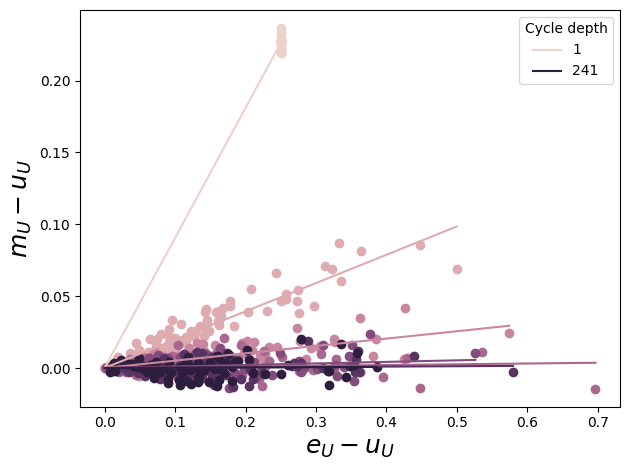

In [246]:
%matplotlib inline
from matplotlib import pyplot as plt

# Color by cycle depth
import seaborn as sns

colors = sns.cubehelix_palette(n_colors=len(depths))
colors = {k: colors[i] for i, k in enumerate(depths)}

_lines = []


def per_cycle_depth(df):
    fid_lsq = df["numerator"].sum() / df["denominator"].sum()

    cycle_depth = df.name
    xx = np.linspace(0, df["x"].max())
    (l,) = plt.plot(xx, fid_lsq * xx, color=colors[cycle_depth])
    plt.scatter(df["x"], df["y"], color=colors[cycle_depth])

    global _lines
    _lines += [l]  # for legend
    return pd.Series({"fidelity": fid_lsq})


fids = df.groupby("depth").apply(per_cycle_depth).reset_index()
plt.xlabel(r"$e_U - u_U$", fontsize=18)
plt.ylabel(r"$m_U - u_U$", fontsize=18)
_lines = np.asarray(_lines)
plt.legend(_lines[[0, -1]], depths[[0, -1]], loc="best", title="Cycle depth")
plt.tight_layout()

# Fidelity plot

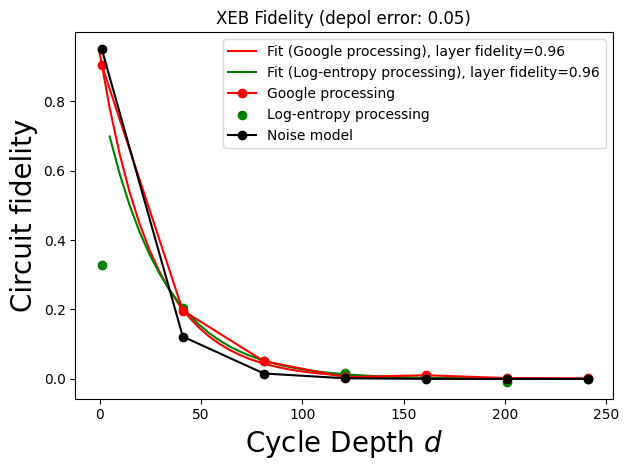

In [247]:
from typing import Tuple
from scipy import optimize
from scipy import stats


# Fit the data
def exponential_decay(cycle_depths: np.ndarray, a: float, layer_fid: float) -> np.ndarray:
    """An exponential decay for fitting.

    This computes `a * layer_fid**cycle_depths`

    Args:
        cycle_depths: The various depths at which fidelity was estimated. This is the independent
            variable in the exponential function.
        a: A scale parameter in the exponential function.
        layer_fid: The base of the exponent in the exponential function.
    """
    return a * layer_fid**cycle_depths

def _fit_exponential_decay(
    cycle_depths: np.ndarray, fidelities: np.ndarray
) -> Tuple[float, float, float, float]:
    """Fit an exponential model fidelity = a * layer_fid**x using nonlinear least squares.

    This uses `exponential_decay` as the function to fit with parameters `a` and `layer_fid`.

    Args:
        cycle_depths: The various depths at which fidelity was estimated. Each element is `x`
            in the fit expression.
        fidelities: The estimated fidelities for each cycle depth. Each element is `fidelity`
            in the fit expression.

    Returns:
        a: The first fit parameter that scales the exponential function, perhaps accounting for
            state prep and measurement (SPAM) error.
        layer_fid: The second fit parameters which serves as the base of the exponential.
        a_std: The standard deviation of the `a` parameter estimate.
        layer_fid_std: The standard deviation of the `layer_fid` parameter estimate.
    """
    cycle_depths = np.asarray(cycle_depths)
    fidelities = np.asarray(fidelities)

    # Get initial guess by linear least squares with logarithm of model.
    # This only works for positive fidelities. We use numpy fancy indexing
    # with `positives` (an ndarray of bools).
    positives = fidelities > 0
    if np.sum(positives) <= 1:
        # The sum of the boolean array is the number of `True` entries.
        # For one or fewer positive values, we cannot perform the linear fit.
        return 0, 0, np.inf, np.inf
    cycle_depths_pos = cycle_depths[positives]
    log_fidelities = np.log(fidelities[positives])

    slope, intercept, _, _, _ = stats.linregress(cycle_depths_pos, log_fidelities)
    layer_fid_0 = np.clip(np.exp(slope), 0, 1)
    a_0 = np.clip(np.exp(intercept), 0, 1)

    try:
        (a, layer_fid), pcov = optimize.curve_fit(
            exponential_decay,
            cycle_depths,
            fidelities,
            p0=(a_0, layer_fid_0),
            bounds=((0, 0), (1, 1)),
        )
    except ValueError:  # pragma: no cover
        return 0, 0, np.inf, np.inf

    a_std, layer_fid_std = np.sqrt(np.diag(pcov))
    return a, layer_fid, a_std, layer_fid_std

fit_google = True
fit_log_entropy = True
xx = np.linspace(0, fids["depth"].max())
# In XEB, we extract the depolarizing fidelity, which is
# related to (but not equal to) the Pauli error.
# For the latter, an error involves doing X, Y, or Z with E_PAULI/3
# but for the former, an error involves doing I, X, Y, or Z with e_depol/4
try:
    a, layer_fid, a_std, layer_fid_std = _fit_exponential_decay(fids["depth"], fids["fidelity"])
    plt.plot(xx, exponential_decay(xx, a, layer_fid),
         label='Fit (Google processing), layer fidelity={:.2f}'.format(layer_fid),
         color='red')
except:
    print("Fit for Google processing data failed")
    fit_google = False

try:
    a2, layer_fid2, a_std2, layer_fid_std2 = _fit_exponential_decay(depths[1:], Fxeb[1:])
    plt.plot(xx[1:], exponential_decay(xx[1:], a2, layer_fid2),
        label="Fit (Log-entropy processing), layer fidelity={:.2f}".format(layer_fid),
        color="green")
    
except:
    print("Fit for Log-entropy processing data failed")
    fit_log_entropy = False
    
    
plt.plot(fids["depth"], fids["fidelity"], marker="o", color= 'red', label="Google processing")

plt.scatter(depths, Fxeb, marker = 'o',
            color='green', label="Log-entropy processing")
# plt.plot(depths, Flinear, marker="o", color="blue", label="Linear XEB")
plt.plot(depths, Fnoise, marker="o", color="black", label="Noise model")
plt.ylabel("Circuit fidelity", fontsize=20)
plt.xlabel("Cycle Depth $d$", fontsize=20)
plt.title(f"XEB Fidelity (depol error: {effective_error})")
plt.legend(loc="best")
# plt.yscale("log")
plt.tight_layout()
plt.show()

In [248]:
if fit_google:
    print("Google processing fit:")
    print("Params: ", a, layer_fid)
    print("Error per cycle: ", layer_fid)
if fit_log_entropy:
    print("Log-entropy processing fit:")
    print("Params: ", a2, layer_fid2)
    print("Error per cycle: ", layer_fid2)

Google processing fit:
Params:  0.9389436189510961 0.9629628604916328
Error per cycle:  0.9629628604916328
Log-entropy processing fit:
Params:  0.8247103256135841 0.9666700415993925
Error per cycle:  0.9666700415993925


In [249]:
print(f"Currently used in the QM XEB example:\n {Fxeb}") # Derived from the fSim paper
print(f'Linear XEB of Google:\n {fids["fidelity"]}') # from Google's Supremacy paper

Currently used in the QM XEB example:
 [ 3.28543210e-01  2.05697489e-01  5.09020123e-02  1.77488876e-02
  6.59975060e-03 -8.94589828e-03 -2.30993748e-04]
Linear XEB of Google:
 0    0.904480
1    0.196973
2    0.051183
3    0.005246
4    0.010691
5    0.002541
6    0.001929
Name: fidelity, dtype: float64


In [250]:
print("absolute difference", np.abs(fids["fidelity"] - Fxeb))

absolute difference 0    0.575937
1    0.008724
2    0.000281
3    0.012503
4    0.004091
5    0.011487
6    0.002160
Name: fidelity, dtype: float64


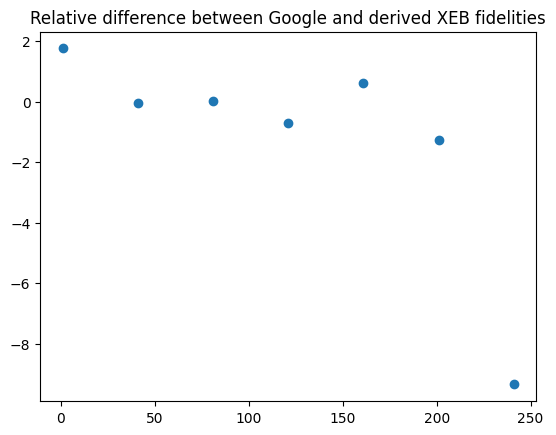

In [251]:
plt.title("Relative difference between Google and derived XEB fidelities")
plt.plot(depths, (fids["fidelity"]-Fxeb)/Fxeb, 'o', label="XEB fidelity")
